In [1]:
from datetime import date, timedelta
import datetime as dt
from dateutil.parser import parse
from typing import Sequence
from pathlib import Path
import sh 
import gc

from PIL import Image


import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib import figure
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.cm         as cm
import matplotlib.colors     as mcolors
import matplotlib.patches    as mpatches
import matplotlib.transforms as mtransforms
import matplotlib.dates      as mdates

import matplotlib

from netCDF4 import Dataset
import geomagdata as gi
import pyproj

import pylab
from pylab import *
import pywt 

import scipy.io        as scio
import scipy.constants as const
from   scipy.fftpack   import fft
from   scipy.stats     import chi2
from scipy.signal import butter, filtfilt, savgol_filter


In [2]:
def FFT(Fs, data):
    L = len(data)

    N = np.power(2, np.ceil(np.log2(L)))
    N = int(N)

    FFT_y = np.abs(fft(data,N))/L*2
    Fre   = np.arange(int(N/2))*Fs/N
    FFT_y = FFT_y[range(int(N/2))]
    
    return Fre, FFT_y

# 计算lags阶以内的自相关系数，返回lags个值，将序列均值、标准差视为不变
def autocorrelation(x,lags):
    n = len(x)
    x = np.array(x)
    variance = x.var()
    x = x-x.mean()
    result = np.correlate(x, x, mode = 'full')[-n+1:-n+lags+1]/\
    (variance*(np.arange(n-1,n-1-lags,-1)))
    return result




In [3]:
def lla2ecef(lon, lat, alt):
    lla = {"proj":'latlong', "ellps":'WGS84', "datum":'WGS84'}
    ecef = {"proj":'geocent', "ellps":'WGS84', "datum":'WGS84'}
    transformer = pyproj.Transformer.from_crs(lla,ecef,always_xy = True)
    return transformer.transform(lon,lat,alt,radians = False)

def ecef2lla(x, y, z):
    lla = {"proj":'latlong', "ellps":'WGS84', "datum":'WGS84'}
    ecef = {"proj":'geocent', "ellps":'WGS84', "datum":'WGS84'}
    transformer = pyproj.Transformer.from_crs(ecef,lla,always_xy = True)
    return transformer.transform(x,y,z,radians = False)

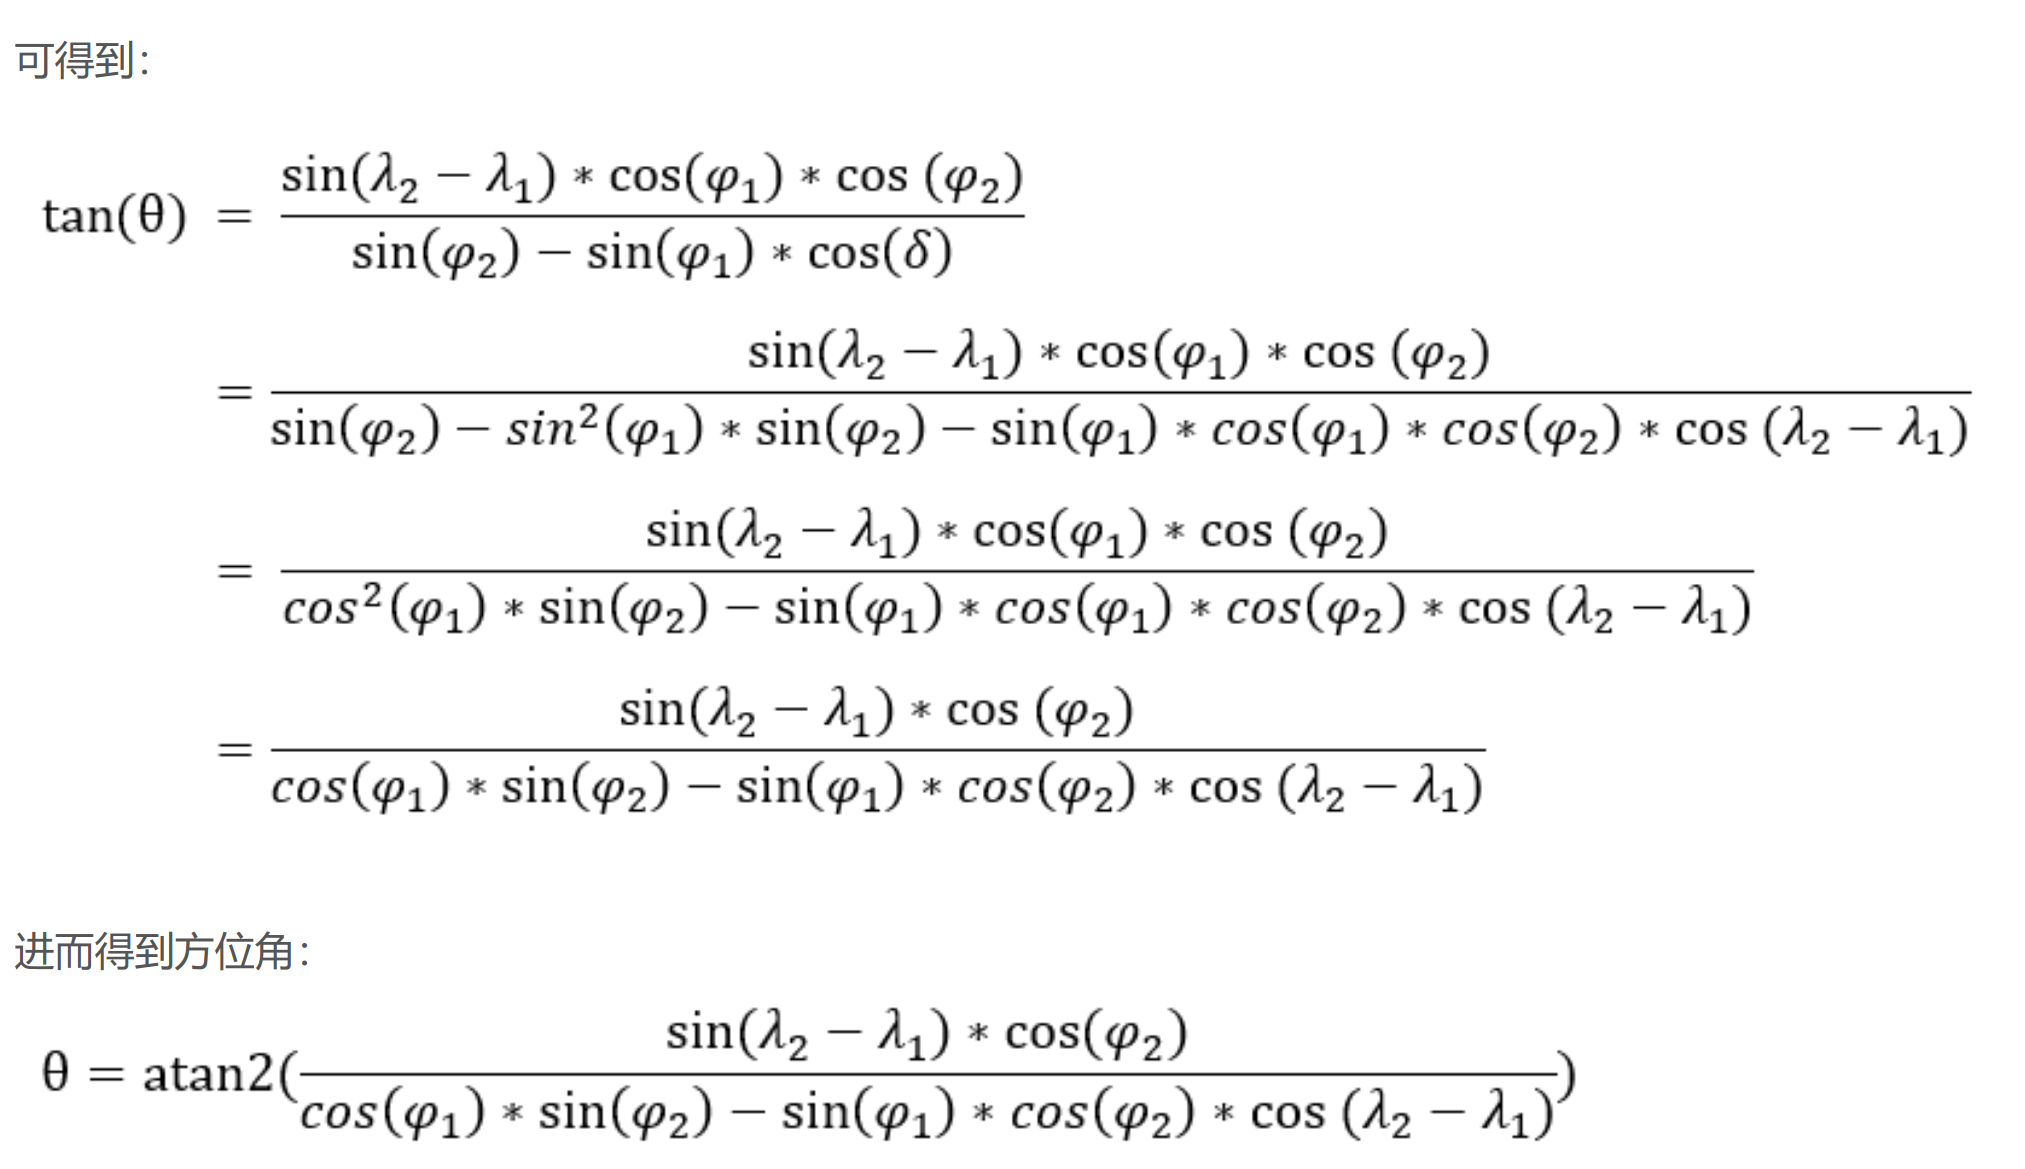

In [4]:
def distance_bearing_between(epicenter_ll, IPP_ll, radians = False):
    
    """ units: km """    
    
#     radium = 6378+400
    # Height =  400*1000
    Height = 0
    
    lambda_a, phi_a = epicenter_ll
    lambda_b, phi_b = IPP_ll
    
    x1, y1, z1 = lla2ecef(lambda_a, phi_a, Height)
    x2, y2, z2 = lla2ecef(lambda_b, phi_b, Height)
    
    vector1 = np.array([x1, y1, z1])
    radium1 = np.sqrt(np.dot(vector1, vector1))/1000
    
    vector2 = np.array([x2, y2, z2])
    radium2 = np.sqrt(np.dot(vector2, vector2))/1000
    
    radium = (radium1 + radium2)/2
#     print('radium:', radium)
    
    if not radians:
        lambda_a = np.radians(lambda_a)
        lambda_b = np.radians(lambda_b)
        phi_a    = np.radians(phi_a)
        phi_b    = np.radians(phi_b)
    
    cosine = np.cos(phi_a)*np.cos(phi_b)*np.cos(lambda_a-lambda_b) + \
             np.sin(phi_a)*np.sin(phi_b)
    
    delta  = np.arccos(cosine)
    distance = radium * delta
    
    tangent = np.sin(lambda_b - lambda_a) * np.cos(phi_b) * np.cos(phi_a) / ( np.sin(phi_b) - np.sin(phi_a) * cosine )
    bearing = np.arctan2(abs(tangent), 1)
    
    if lambda_b > lambda_a:
        if phi_b > phi_a:
            bearing = bearing
        elif phi_b < phi_a:
            bearing = np.pi - bearing
        else:
            bearing = np.pi/2
            
    elif lambda_b < lambda_a:
        if phi_b > phi_a:
            bearing = 2*np.pi - bearing
        elif phi_b < phi_a:
            bearing = np.pi + bearing
        else:
            bearing = 3 * np.pi/2
            
    else:
        if phi_b >= phi_a :
            bearing = 0
        elif phi_b < phi_a:
            bearing = np.pi
            
    quarter = np.pi/4
    
    if bearing >= 0 and bearing < quarter:
        direction = 'N.E.'
        
    elif bearing >= quarter and bearing < 2 * quarter:
        direction = 'E.N.'
        
    elif bearing >= 2 * quarter and bearing < 3 * quarter:
        direction = 'E.S.'
        
    elif bearing >= 3 * quarter and bearing < 4 * quarter:
        direction = 'S.E.'
        
    elif bearing >= 4 * quarter and bearing < 5 * quarter: 
        direction = 'S.W.'
        
    elif bearing >= 5 * quarter and bearing < 6 * quarter:
        direction = 'W.S.'
        
    elif bearing >= 6 * quarter and bearing < 7 * quarter:
        direction = 'W.N.'
        
    else:
        direction = 'N.W.'

#     if np.degrees(bearing) >= 337.5 or np.degrees(bearing) < 22.5:
#         direction = 'N. '
        
#     elif np.degrees(bearing) >= 22.5 and np.degrees(bearing) < 67.5:
#         direction = 'NE.'
        
#     elif np.degrees(bearing) >= 67.5 and np.degrees(bearing) < 112.5:
#         direction = 'E. '
        
#     elif np.degrees(bearing) >= 112.5 and np.degrees(bearing) < 157.5:
#         direction = 'SE.'
        
#     elif np.degrees(bearing) >= 157.5 and np.degrees(bearing) < 202.5:
#         direction = 'S. '
        
#     elif np.degrees(bearing) >= 202.5 and np.degrees(bearing) < 247.5:
#         direction = 'SW.'
        
#     elif np.degrees(bearing) >= 247.5 and np.degrees(bearing) < 292.5:
#         direction = 'W. '
        
#     elif np.degrees(bearing) >= 292.5 and np.degrees(bearing) < 337.5:
#         direction = 'NW.'
        
#     else:
#         direction = 'W. '
        
    return distance, bearing, direction

In [5]:
def data_trend(dat, level = 2):
    winsize = len(dat)
    t   = np.arange(1,winsize+1,1)
    idx = np.isfinite(dat)
    p   = np.polyfit(t[idx], dat[idx], level)
#             p            = np.polyfit(t, dat, 1)
#     trend = np.polyval(p, t)
    return p


In [6]:
class Signal(object):
    def __init__(self, signals, sample_rate):
        self.name = 'signals'
        # self.signals = signals
        self.sample_rate = sample_rate
        
        nan_idx      = np.isnan(signals)
        # 找到数组中非 NaN 值的位置
        not_nan_idx = np.logical_not(nan_idx)
        # 使用插值函数 interp() 对 NaN 值进行插值
        signals[nan_idx] = np.interp(nan_idx.nonzero()[0], not_nan_idx.nonzero()[0], signals[not_nan_idx])
        self.signals = signals

    def butter_bandpass(self, cut_off_frequency_list, order=3):
        ''' 带通滤波器，需要两个截止频率，以 list 形式输入 '''
        self.nyq = 0.5 * self.sample_rate
        normal_cut_off = np.array(cut_off_frequency_list) / self.nyq
        b, a = butter(order, normal_cut_off,
                      btype="bandpass", analog=False)
        return b, a

    def butter_bandpass_filtfilt(self, cut_off_frequency_list, order=3):
        ''' 带通滤波器的执行，消除延迟 '''
        b, a = self.butter_bandpass(cut_off_frequency_list, order=order)
        y = filtfilt(b, a, self.signals)
        return y
    
    def savgol_dtrend_filter(self, winlong, winshort, order = 3):
        trend  = savgol_filter(self.signals, winlong ,order)
        if winshort == 0:
            dtrend = self.signals - trend
            return dtrend
        else: 
            dtrend = self.signals - trend
            bandpass = savgol_filter(dtrend, winshort ,order)
            return bandpass
    

In [7]:
def format_func(x, 
                pos=None
               ):
    x = mdates.num2date(x)
    
    if x.hour == 0 and x.minute == 0:
        fmt = '%d\n%b'
#     elif 
#         fmt = '%H\n%m/%d'
    else:
        fmt = '%H'
        
    label = x.strftime(fmt)
    
    return label


def add_right_cax(ax, pad, width):
    '''
    在一个ax右边追加与之等高的cax.
    pad是cax与ax的间距,width是cax的宽度.
    '''
    axpos = ax.get_position()
    caxpos = mtransforms.Bbox.from_extents(
        axpos.x1 + pad,
        axpos.y0,
        axpos.x1 + pad + width,
        axpos.y1
    )
    cax = ax.figure.add_axes(caxpos)

    return cax

In [8]:
def plot_time_distance_variation(ax, time, distances, data, vmin = -1.6, vmax = 1.6, cmap = 'bwr'):  
    for i, distance in enumerate(distances):
        D = [distance]*len(time) 
        im = ax.scatter(time, D, 
                        c = data[i],
                        vmin = vmin,
                        vmax = vmax,
                        s = 5,
                        marker = ',',
                        linewidths = 0,
                        cmap = cmap
                       )
    return im

In [9]:
def plot_time_distance_vibration(ax, time, distances, data, vmin = -1.6, vmax = 1.6, cmap = 'bwr'):  
    for i, distance in enumerate(distances):
        # D = [distance]*len(time) 
        sc = ax.scatter(time, distance+data[i], 
                     c = distance+data[i],
                        vmin = distance+vmin,
                        vmax = distance+vmax,
                        s = 0.8,
                        marker = ',',
                        linewidths = 0,
                        cmap = cmap
                       )
#         ax.axhline( distance,
#             linestyle = '--',
#             color = 'grey',
#             alpha = 0.25,
#                    linewidth = 0.02
# #             zorder = -100
#            )
    return sc

In [10]:
def plot_arrival_time_line(ax, tstart, tend, pstart, pend, notes = 'notation', portion = 0.25):
    ax.plot([tstart, tend], [pstart, pend], color = 'grey', alpha = 0.35)
    ax.annotate(notes, 
                [tstart+(tend-tstart)*portion, pstart+(pend-pstart)*portion], 
                xytext=[10,0], 
                textcoords='offset points'
                )

In [11]:
obs = {}
sample_rate= 1
direction = 'NW'

# lowlimit   = 1/3600
# highlimit  = 0.49
# filtering = '1hr-2s Butterworth filter'             # order: 5
# zoomer = 15
# cut_off_frequency_list = [lowlimit, highlimit]
# vmin = -1.6      # scatter plot paarmeter
# vmax = 1.6

# lowlimit   = 1.0/(50*60)
# highlimit  = 1.0/(30*60)
# filtering = '50min-30min Butterworth filter'        # order: 3
# zoomer = 15
# cut_off_frequency_list = [lowlimit, highlimit]
# vmin = -1.1
# vmax = 1.1


# lowlimit   = 1.0/(20*60)
# highlimit  = 1.0/(12*60)
# filtering = '20min-12min Butterworth filter'        # order: 3
# zoomer = 15
# cut_off_frequency_list = [lowlimit, highlimit]
# vmin = -0.8
# vmax = 0.8



# SGwinsize = 60*60+1                        # should be odd 
# filtering = '60min Savitzky-Golay detrended'            # order: 5

winlong = 60*60+1
winshort = 50*60+1                        # should be odd 
filtering = '60min-50min overlay Savitzky-Golay detrended'            # order: 3
# filtering = '60min-50min composite Savitzky-Golay detrended'            # order: 3
# vmin = -1.2    # 1.5
# vmax = -vmin
# zoomer = 100

# SGwinsize = 40*60+1                        # should be odd 
# filtering = '40min Savitzky-Golay detrended'            # order: 5
# vmin = -2
# vmax = -vmin

# SGwinsize = 30*60+1                        # should be odd 
# filtering = '30min Savitzky-Golay detrended'            # order: 5
# vmin = -1.6
# vmax = -vmin
# zoomer = 15

event_date       = datetime.date(2022,9,5).strftime('%Y_%m_%d')
epicenter        = 'Luding'
epictime         = np.datetime64('2022-09-05T04:52','m')
src_dir  = Path(f'/run/media/echoo/TOSHIBA EXT/GNSS/{event_date}_{epicenter}')

save_dir  = Path(f'/home/echoo/echoo/mycode/PLOT/{event_date}_{epicenter}')
epicenter_ll    = [102.08, 29.59]


# save_dir
if not Path.is_dir(save_dir):
    sh.mkdir(save_dir)
# 
#     C01 - 地球静止轨道140.0°E，高度35807×35782公里，倾角1.6°
#     C02 - 地球静止轨道84.07°E，高度35803×35783公里，倾角1.7°
#     C03 - 地球静止轨道110.45°E，高度35854.3×35885.9公里，倾角1.7°
#     C04 - 地球静止轨道159.98°E，高度35815×35772公里，倾角0.6°
#     C05 - 地球静止轨道58.71°E，高度35801×35786公里，倾角1.4°

svs = [ 'C01', 'C03', 'C02', 'C05']

observers = set()
observer_svs = {}

start = dt.datetime(2022, 9, 4)
end   = dt.datetime(2022, 9, 6)



is_first_day = True
for date in pd.date_range(start, 
                          end-timedelta(days=1), 
                          freq="D"
                         ):
    obs['year']      = date.strftime('%y')
    obs['doy']       = date.strftime('%j')
    obs['samp_rate'] = '01s'

    # src_dir  = Path(f"/run/media/echoo/TOSHIBA EXT")

    TEC_dir  = src_dir/obs['doy']/'TEC'
    TEC_file = f"TEC_{obs['doy']}_{obs['samp_rate']}_{obs['year']}.nc"
    TEC_path = TEC_dir/TEC_file
    
    nc = xr.open_dataset(TEC_path)
    if is_first_day:
        observers = set(nc.observer.values)
    else:
        observers = observers.intersection(set(nc.observer.values) )
    
        
    for observer in observers:
        if is_first_day:
            observer_svs[observer] = svs.copy()
        for sv in svs:
            try:
                sTEC   = nc.sTEC_smth.sel(observer = observer, sv = sv).dropna(dim = 'time') 
                zenith = nc.zenith.sel(observer = observer, sv = sv)
            except:
                observer_svs[observer].remove(sv)
                continue
            
            if len(sTEC) < 40000:
                observer_svs[observer].remove(sv)
            try:
                elevation  = 90 - np.degrees(zenith.values)
                if elevation < 32:
                    observer_svs[observer].remove(sv)
            except:
                pass
# lons = nc.sel(sv = 'C03').lon.dropna(dim = 'observer').values
# lons = sorted(lons, reverse = True)
remove_set = set(['SCSM', 'YNLJ', 'YNYM', 'SCJU'])
observers = observers.difference(remove_set)

try:
    observer_svs['SCGU'].remove('C03')
except:
    pass

try:
    observer_svs['SCGU'].remove('C03')
except:
    pass

try:
    observer_svs['SCGU'].remove('C05')
except:
    pass

try:
    observer_svs['SCSP'].remove('C05')
except:
    pass

try:
    observer_svs['SCLT'].remove('C05')
except:
    pass

try:
    observer_svs['SCSN'].remove('C05')
except:
    pass

try:
    observer_svs['GSLZ'].remove('C05')
except:
    pass

try:
    observer_svs['GSTS'].remove('C05')
except:
    pass

del nc, sTEC

# data = xr.Dataset()

# is_first_obser = True
# for obs_count, observer in enumerate(observers):
    
#     print(len(observers), obs_count, observer)
    
#     sv_count = len(observer_svs[observer])
#     for count, sv in enumerate(observer_svs[observer]):
#         is_first_day = True
#         for date in pd.date_range(start, 
#                                   end-timedelta(days=1), 
#                                   freq="D"
#                                  ):
#             obs['year']      = date.strftime('%y')
#             obs['doy']       = date.strftime('%j')
#             obs['samp_rate'] = '01s'

#             # src_dir  = Path(f"/run/media/echoo/TOSHIBA EXT")

#             TEC_dir  = src_dir/obs['doy']/'TEC'
#             TEC_file = f"TEC_{obs['doy']}_{obs['samp_rate']}_{obs['year']}.nc"
#             TEC_path = TEC_dir/TEC_file
#             nc = xr.open_dataset(TEC_path)
                
#             sTEC   = nc.sTEC_smth.sel(observer = observer, sv = sv)
# #             print(sTEC)
#             zenith = nc.zenith.sel(observer = observer, sv = sv)
#             vTEC    =  sTEC * np.cos(zenith)
            
#             thetime = vTEC.time  
            
#             if len(vTEC) == 0:
#                 break
                
#             IPP_ll       = vTEC.lon.values, vTEC.lat.values
#             distance, bearing, dire = distance_bearing_between(epicenter_ll, IPP_ll)
        
        
#             if dire == direction:
#                 # print(IPP_ll, '\n', distance, np.degrees(bearing), dire)
#                 pass
#             else:
#                 break
                
#             data         = vTEC.values

#             TEC          = Signal(data, sample_rate)
#             # TEC_filtered = TEC.butter_bandpass_filtfilt(cut_off_frequency_list)
#             TEC_dtrend = TEC.savgol_dtrend_filter(SGwinsize)
#     #         std          = np.sqrt((TEC_filtered**2).mean())
#     #         norm         = (TEC_filtered - TEC_filtered.mean()) / std
#             # norm         = TEC_filtered
#             dtrend_daily   = TEC_dtrend
#             # dtrend_daily   = dtrend_daily .reshape((1,-1))

#             if is_first_day:
#                 dtrend     = dtrend_daily
#                 time       = thetime
#             else:
#                 dtrend     = np.hstack((dtrend  , dtrend_daily))
#                 time       = xr.concat([time  , thetime]    , dim = 'time')
             
#             is_first_day = False
            
#             del nc 
#             gc.collect()
            
#         if dire == direction:
#             print(IPP_ll, sv, '\n', distance, np.degrees(bearing), dire)
#         else:
#             continue
                
#         if is_first_obser:
#             # TECdata = vTEC.values.reshape((1,-1))
#             data_dtrend = dtrend
#             distances = np.array(distance)
#         else:
#             # TECdata = np.vstack((TECdata, vTEC.values.reshape((1,-1))))
#             data_dtrend = np.vstack((data_dtrend, dtrend))
#             distances = np.vstack((distances, distance))
        
#         is_first_obser = False
        
#         del dtrend, distance
#         gc.collect()

In [12]:
# help(fig.suptitle)

27 7 QHBM
(array(101.64496483), array(30.30894587)) C03 
 90.29042930842992 332.4403132661491 N.W.
27 22 QHMQ
(array(101.22889618), array(31.71357509)) C03 
 249.8323378556928 341.1919424448392 N.W.
27 26 GSLZ
(array(100.99933909), array(33.10386343)) C02 
 404.0546918344768 345.5622019290342 N.W.
27 18 GSWD
(array(102.16053393), array(30.70732224)) C02 
 124.51632495995635 3.5463120211122368 N.E.
27 19 GSTS
(array(103.05775757), array(31.65106153)) C02 
 247.60090766404193 21.960018816028846 N.E.
27 26 GSLZ
(array(104.32414168), array(33.14525872)) C03 
 449.14879611602146 27.74547329675378 N.E.
27 7 QHBM
(array(98.58944726), array(30.28504654)) C02 
 345.1918380642718 283.80816356199017 W.N.
27 7 QHBM
(array(95.60888529), array(30.1656814)) C05 
 627.2901613649067 277.46484019893705 W.N.
27 15 SCSP
(array(101.13032198), array(30.02061521)) C02 
 103.4170493431104 297.8250656045467 W.N.
27 18 GSWD
(array(98.83397817), array(30.56058627)) C05 
 330.5429126112755 289.8700184761812 W.N.


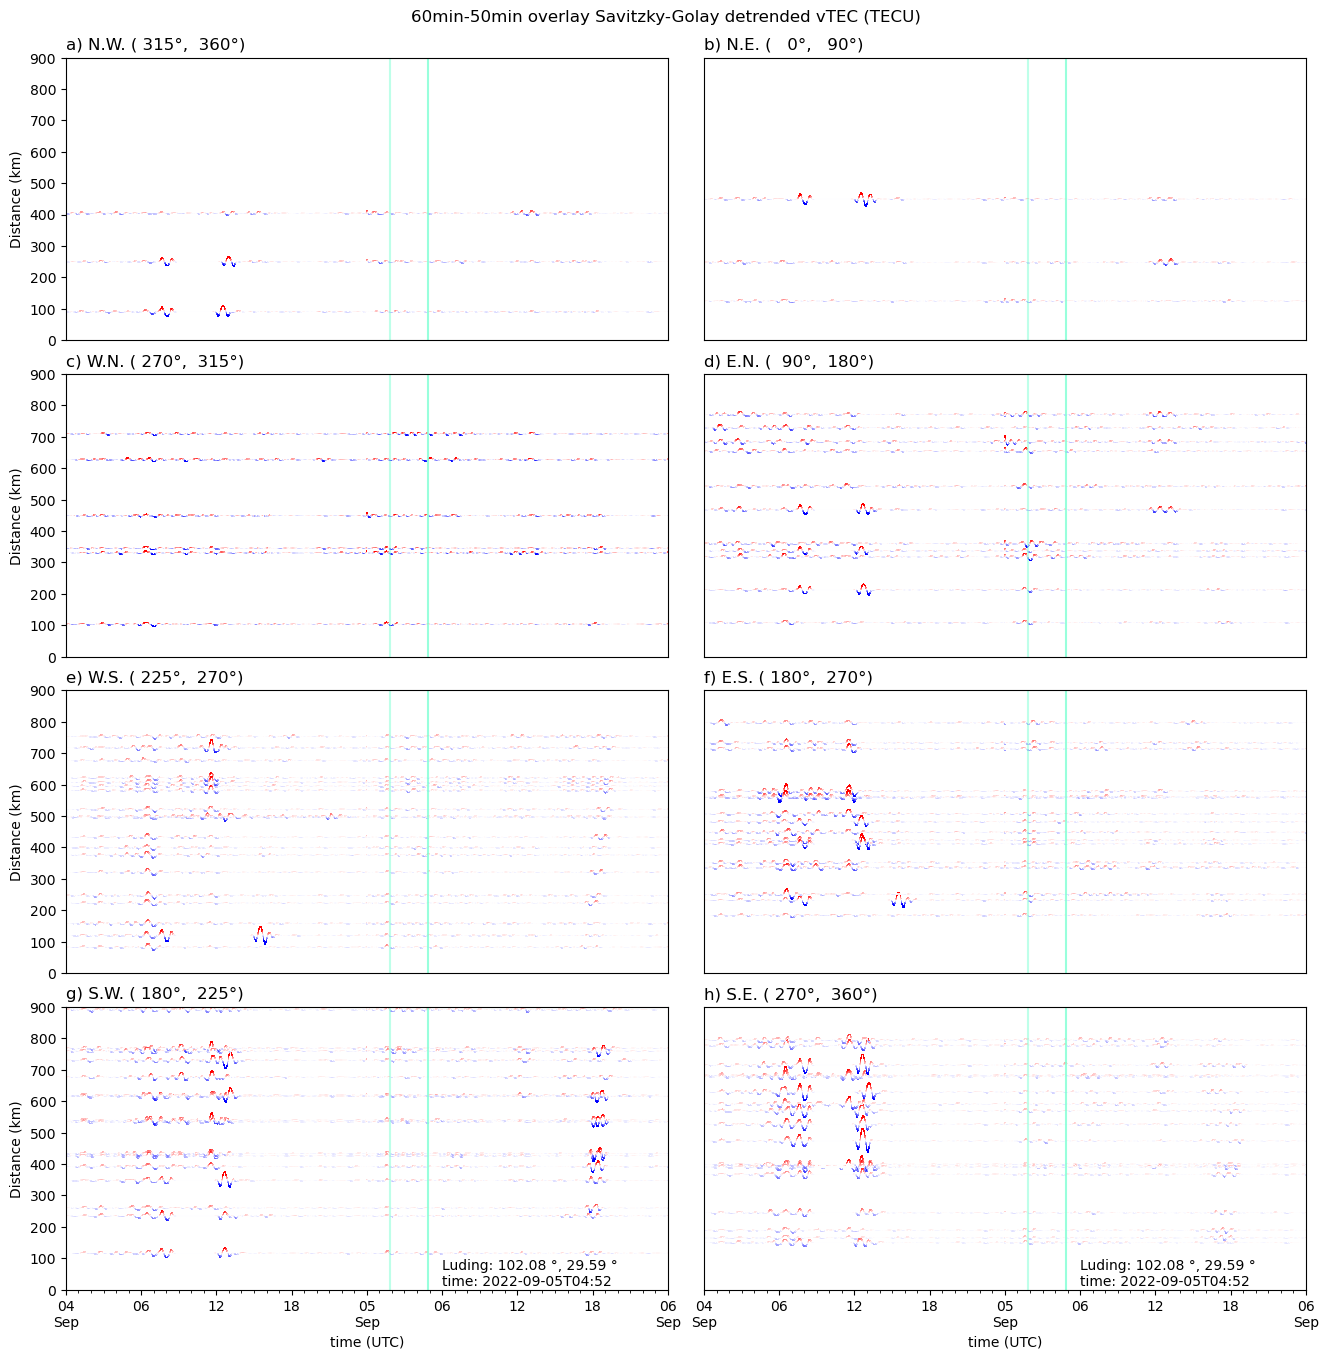

9252

In [13]:
fig = figure(figsize = (16, 16))
axs = fig.subplots(4, 2)
# plt.title(f'{filtering} vTEC (TECU)')
fig.suptitle(f'{filtering} vTEC (TECU)', x = 0.5, y = 0.91)
directions = [['N.W.','N.E.'], ['W.N.', 'E.N.'], ['W.S.', 'E.S.'], ['S.W.', 'S.E.']]
# directions = [['N. ','NE.'], ['NW.', 'E. '], ['W. ', 'SE.'], ['SW.', 'S. ']]


direction_span = {}
for row, row_direction in enumerate(directions):
    for col, direction in enumerate(row_direction):
        if col == 1:
            direction_span[direction] = f'({row*90:4d}\N{DEGREE SIGN}, {(row+1)*90:4d}\N{DEGREE SIGN})'
        elif col == 0:
            direction_span[direction] = f'({(7-row)*45:4d}\N{DEGREE SIGN}, {(8-row)*45:4d}\N{DEGREE SIGN})'
# direction_span['N. '] = f'( 337.5\N{DEGREE SIGN},   22.5\N{DEGREE SIGN})'
# direction_span['NE.'] = f'(  22.5\N{DEGREE SIGN},   67.5\N{DEGREE SIGN})'
# direction_span['E. '] = f'(  67.5\N{DEGREE SIGN},  112.5\N{DEGREE SIGN})'
# direction_span['SE.'] = f'( 112.5\N{DEGREE SIGN},  157.5\N{DEGREE SIGN})'
# direction_span['S. '] = f'( 157.5\N{DEGREE SIGN},  202.5\N{DEGREE SIGN})'
# direction_span['SW.'] = f'( 202.5\N{DEGREE SIGN},  247.5\N{DEGREE SIGN})'
# direction_span['W. '] = f'( 247.5\N{DEGREE SIGN},  292.5\N{DEGREE SIGN})'
# direction_span['NW.'] = f'( 292.5\N{DEGREE SIGN},  337.5\N{DEGREE SIGN})'

for row, row_direction in enumerate(directions):
    for col, direction in enumerate(row_direction):
        data = xr.Dataset()

        is_first_obser = True
        for obs_count, observer in enumerate(observers):

            # print(len(observers), obs_count, observer)

            sv_count = len(observer_svs[observer])
            for count, sv in enumerate(observer_svs[observer]):
                is_first_day = True
                for date in pd.date_range(start, 
                                          end-timedelta(days=1), 
                                          freq="D"
                                         ):
                    obs['year']      = date.strftime('%y')
                    obs['doy']       = date.strftime('%j')
                    obs['samp_rate'] = '01s'

                    # src_dir  = Path(f"/run/media/echoo/TOSHIBA EXT")

                    TEC_dir  = src_dir/obs['doy']/'TEC'
                    TEC_file = f"TEC_{obs['doy']}_{obs['samp_rate']}_{obs['year']}.nc"
                    TEC_path = TEC_dir/TEC_file
                    nc = xr.open_dataset(TEC_path)

                    sTEC   = nc.sTEC_smth.sel(observer = observer, sv = sv)
        #             print(sTEC)
                    zenith = nc.zenith.sel(observer = observer, sv = sv)
                    vTEC    =  sTEC * np.cos(zenith)

                    thetime = vTEC.time  

                    if len(vTEC) == 0:
                        break

                    IPP_ll       = vTEC.lon.values, vTEC.lat.values
                    distance, bearing, dire = distance_bearing_between(epicenter_ll, IPP_ll)


                    if dire == direction:
                        # print(IPP_ll, '\n', distance, np.degrees(bearing), dire)
                        pass
                    else:
                        break

                    data           = vTEC.values

                    TEC            = Signal(data, sample_rate)
                    # TEC_filtered = TEC.butter_bandpass_filtfilt(cut_off_frequency_list)
                    TEC_filtered   = TEC.savgol_dtrend_filter(winlong, winshort)
                    filtered_daily = TEC_filtered
                    
                    
                    # TEC_dtrend = TEC.savgol_dtrend_filter(SGwinsize)
                    # dtrend_daily   = TEC_dtrend

                    if is_first_day:
                        # dtrend     = dtrend_daily
                        filtered   = filtered_daily
                        time       = thetime
                    else:
                        # dtrend     = np.hstack((dtrend, dtrend_daily))
                        filtered   = np.hstack((filtered, filtered_daily))
                        time       = xr.concat([time  , thetime], dim = 'time')

                    is_first_day = False

                    del nc 
                    gc.collect()

                if dire == direction:
                    print(len(observers), obs_count, observer)
                    print(IPP_ll, sv, '\n', distance, np.degrees(bearing), dire)
                else:
                    continue

                if is_first_obser:
                    data_filtered = filtered
                    # data_dtrend = dtrend
                    distances = np.array(distance)
                else:
                    # TECdata = np.vstack((TECdata, vTEC.values.reshape((1,-1))))
                    # data_dtrend = np.vstack((data_dtrend, 
                    #                          dtrend)
                    #                        )
                    data_filtered = np.vstack((data_filtered, 
                                             filtered)
                                           )
                    distances = np.vstack((distances, 
                                           distance)
                                         )

                is_first_obser = False

                del filtered, distance
                gc.collect()
                
        # vmax = (abs(min(data_dtrend))+ abs(max(data_dtrend)))/3.5
        vmax = (abs(min(data_filtered))+ abs(max(data_filtered)))/3.5
        vmin = -vmax
        zoomer = 60
        
        # plot_time_distance_vibration(axs[row,col], 
        #                              time, distances, 
        #                              data_dtrend*zoomer, 
        #                              vmin = vmin*zoomer, vmax = vmax*zoomer, 
        #                              cmap = 'bwr')
        
        plot_time_distance_vibration(axs[row,col], 
                                     time, distances, 
                                     data_filtered*zoomer, 
                                     vmin = vmin*zoomer, vmax = vmax*zoomer, 
                                     cmap = 'bwr')
# plt.colorbar(im)

        axs[row,col].axvline(epictime,
           # color = 'crimson',
                             color = 'aquamarine',
                             alpha = 0.8
                            )

        axs[row,col].axvline(epictime - np.timedelta64(3, 'h'),
           # color = 'navy',
                             color = 'aquamarine',
                             alpha = 0.5
                            )

#         notes = f'{epicenter}: {epicenter_ll[0]} \N{DEGREE SIGN}, {epicenter_ll[1]} \N{DEGREE SIGN} \n' \
#         f'time: {epictime}'

#         axs[row,col].annotate(notes, 
#             [epictime, 0 + (max(distances) - min(distances))*0.02], 
#             xytext=[10,0], 
#             textcoords='offset points'
#            )
        
        axs[row,col].set_ylim(0, 900)
        axs[row,col].set_xlim(start, end)
        # axs[row,col].set_xlabel('time (UTC)')
        
        axs[row,col].set_xticks([])
        if col == 1:
            axs[row,col].set_yticks([])
        if col == 0:
            axs[row,col].set_ylabel('Distance (km)')
        
        mark = chr(int(ord('a')+row*2+col))
        # axs[row,col].set_title(f'{filtering} vTEC (TECU)')
        axs[row,col].set_title(f'{mark}) {direction} {direction_span[direction]}', loc = 'left')


notes = f'{epicenter}: {epicenter_ll[0]} \N{DEGREE SIGN}, {epicenter_ll[1]} \N{DEGREE SIGN} \n' \
        f'time: {epictime}'

axs[-1,0].annotate(notes, 
                   [epictime, 0 + (max(distances) - min(distances))*0.02], 
                   xytext=[10,0], 
                   textcoords='offset points'
                  )

axs[-1,1].annotate(notes, 
                   [epictime, 0 + (max(distances) - min(distances))*0.02], 
                   xytext=[10,0], 
                   textcoords='offset points'
                  )

ticks = [0, 6, 12, 18]
axs[-1,0].set_xlim(start, end)
axs[-1,0].xaxis.set_major_locator(mdates.HourLocator(ticks))
axs[-1,0].xaxis.set_minor_locator(mdates.HourLocator())
axs[-1,0].xaxis.set_major_formatter(format_func)
axs[-1,0].set_xlabel('time (UTC)')

axs[-1,1].set_xlim(start, end)
axs[-1,1].xaxis.set_major_locator(mdates.HourLocator(ticks))
axs[-1,1].xaxis.set_minor_locator(mdates.HourLocator())
axs[-1,1].xaxis.set_major_formatter(format_func)
axs[-1,1].set_xlabel('time (UTC)')

fig.subplots_adjust(hspace = 0.12, wspace = 0.06)
fig.align_ylabels()
# fig.suptitle(f'{filtering} vTEC (TECU)', pad = 0.15)
show()

savefile  = save_dir/f'detrended_vTEC_time_distance_{filtering}_vibration_{epicenter}.png'
fig.savefig(savefile, 
            bbox_inches = 'tight', 
            dpi = 600
           )

fig.clf()
plt.clf()
plt.close('all')
plt.close(fig)
gc.collect()

In [14]:
data_filtered

array([[-0.07325475, -0.07293873, -0.07262325, ...,  0.02132013,
         0.0214202 ,  0.02152045],
       [-0.02474828, -0.02464221, -0.02453631, ...,  0.02505236,
         0.02516812,  0.02528408],
       [ 0.03454932,  0.03438728,  0.03422556, ..., -0.04328557,
        -0.04348604, -0.04368688],
       ...,
       [-0.06905086, -0.06874935, -0.06844836, ..., -0.01901322,
        -0.01910492, -0.01919679],
       [ 0.06298376,  0.06268967,  0.06239613, ...,  0.00880941,
         0.00884962,  0.00888991],
       [-0.01229349, -0.01224025, -0.0121871 , ...,  0.00041357,
         0.00041353,  0.00041349]])

In [15]:
# fig = figure(figsize = (16, 16))
# axs = fig.subplots(4, 2)
# # plt.title(f'{filtering} vTEC (TECU)')
# fig.suptitle(f'{filtering} vTEC (TECU)', x = 0.5, y = 0.91)
# directions = [['N.W.','N.E.'], ['W.N.', 'E.N.'], ['W.S.', 'E.S.'], ['S.W.', 'S.E.']]

# direction_span = {}
# for row, row_direction in enumerate(directions):
#     for col, direction in enumerate(row_direction):
#         if col == 1:
#             direction_span[direction] = f'({row*45:4d}\N{DEGREE SIGN}, {(row+1)*45:4d}\N{DEGREE SIGN})'
#         elif col == 0:
#             direction_span[direction] = f'({(7-row)*45:4d}\N{DEGREE SIGN}, {(8-row)*45:4d}\N{DEGREE SIGN})'

# for row, row_direction in enumerate(directions):
#     for col, direction in enumerate(row_direction):
#         data = xr.Dataset()

#         is_first_obser = True
#         for obs_count, observer in enumerate(observers):

#             # print(len(observers), obs_count, observer)

#             sv_count = len(observer_svs[observer])
#             for count, sv in enumerate(observer_svs[observer]):
#                 is_first_day = True
#                 for date in pd.date_range(start, 
#                                           end-timedelta(days=1), 
#                                           freq="D"
#                                          ):
#                     obs['year']      = date.strftime('%y')
#                     obs['doy']       = date.strftime('%j')
#                     obs['samp_rate'] = '01s'

#                     # src_dir  = Path(f"/run/media/echoo/TOSHIBA EXT")

#                     TEC_dir  = src_dir/obs['doy']/'TEC'
#                     TEC_file = f"TEC_{obs['doy']}_{obs['samp_rate']}_{obs['year']}.nc"
#                     TEC_path = TEC_dir/TEC_file
#                     nc = xr.open_dataset(TEC_path)

#                     sTEC   = nc.sTEC_smth.sel(observer = observer, sv = sv)
#         #             print(sTEC)
#                     zenith = nc.zenith.sel(observer = observer, sv = sv)
#                     vTEC    =  sTEC * np.cos(zenith)

#                     thetime = vTEC.time  

#                     if len(vTEC) == 0:
#                         break

#                     IPP_ll       = vTEC.lon.values, vTEC.lat.values
#                     distance, bearing, dire = distance_bearing_between(epicenter_ll, IPP_ll)


#                     if dire == direction:
#                         # print(IPP_ll, '\n', distance, np.degrees(bearing), dire)
#                         pass
#                     else:
#                         break

#                     data         = vTEC.values

#                     TEC          = Signal(data, sample_rate)
#                     TEC_filtered = TEC.butter_bandpass_filtfilt(cut_off_frequency_list)
#                     filtered_daily   = TEC_filtered
                    
#                     # TEC_dtrend = TEC.savgol_dtrend_filter(SGwinsize)
#                     # dtrend_daily   = TEC_dtrend

#                     if is_first_day:
#                         # dtrend     = dtrend_daily
#                         filtered   = filtered_daily
#                         time       = thetime
#                     else:
#                         # dtrend     = np.hstack((dtrend, dtrend_daily))
#                         filtered   = np.hstack((filtered, filtered_daily))
#                         time       = xr.concat([time  , thetime], dim = 'time')

#                     is_first_day = False

#                     del nc 
#                     gc.collect()

#                 if dire == direction:
#                     print(len(observers), obs_count, observer)
#                     print(IPP_ll, sv, '\n', distance, np.degrees(bearing), dire)
#                 else:
#                     continue

#                 if is_first_obser:
#                     data_filtered = filtered
#                     # data_dtrend = dtrend
#                     distances = np.array(distance)
#                 else:
#                     # TECdata = np.vstack((TECdata, vTEC.values.reshape((1,-1))))
#                     # data_dtrend = np.vstack((data_dtrend, 
#                     #                          dtrend)
#                     #                        )
#                     data_filtered = np.vstack((data_filtered, 
#                                              filtered)
#                                            )
#                     distances = np.vstack((distances, 
#                                            distance)
#                                          )

#                 is_first_obser = False

#                 del filtered, distance
#                 gc.collect()
                
#         # vmax = (abs(min(data_dtrend))+ abs(max(data_dtrend)))/3.5
#         vmax = (abs(min(data_filtered))+ abs(max(data_filtered)))/3.5
#         vmin = -vmax
#         zoomer = 30
        
#         # plot_time_distance_vibration(axs[row,col], 
#         #                              time, distances, 
#         #                              data_dtrend*zoomer, 
#         #                              vmin = vmin*zoomer, vmax = vmax*zoomer, 
#         #                              cmap = 'bwr')
        
#         plot_time_distance_vibration(axs[row,col], 
#                                      time, distances, 
#                                      data_filtered*zoomer, 
#                                      vmin = vmin*zoomer, vmax = vmax*zoomer, 
#                                      cmap = 'bwr')
# # plt.colorbar(im)

#         axs[row,col].axvline(epictime,
#            # color = 'crimson',
#                              color = 'aquamarine',
#                              alpha = 0.8
#                             )

#         axs[row,col].axvline(epictime - np.timedelta64(3, 'h'),
#            # color = 'navy',
#                              color = 'aquamarine',
#                              alpha = 0.5
#                             )

# #         notes = f'{epicenter}: {epicenter_ll[0]} \N{DEGREE SIGN}, {epicenter_ll[1]} \N{DEGREE SIGN} \n' \
# #         f'time: {epictime}'

# #         axs[row,col].annotate(notes, 
# #             [epictime, 0 + (max(distances) - min(distances))*0.02], 
# #             xytext=[10,0], 
# #             textcoords='offset points'
# #            )
        
#         axs[row,col].set_ylim(0, 900)
#         axs[row,col].set_xlim(start, end)
#         # axs[row,col].set_xlabel('time (UTC)')
        
#         axs[row,col].set_xticks([])
#         if col == 1:
#             axs[row,col].set_yticks([])
#         if col == 0:
#             axs[row,col].set_ylabel('Distance (km)')
        
#         mark = chr(int(ord('a')+row*2+col))
#         # axs[row,col].set_title(f'{filtering} vTEC (TECU)')
#         axs[row,col].set_title(f'{mark}) {direction} {direction_span[direction]}', loc = 'left')


# notes = f'{epicenter}: {epicenter_ll[0]} \N{DEGREE SIGN}, {epicenter_ll[1]} \N{DEGREE SIGN} \n' \
#         f'time: {epictime}'

# axs[-1,0].annotate(notes, 
#                    [epictime, 0 + (max(distances) - min(distances))*0.02], 
#                    xytext=[10,0], 
#                    textcoords='offset points'
#                   )

# axs[-1,1].annotate(notes, 
#                    [epictime, 0 + (max(distances) - min(distances))*0.02], 
#                    xytext=[10,0], 
#                    textcoords='offset points'
#                   )

# ticks = [0, 6, 12, 18]
# axs[-1,0].set_xlim(start, end)
# axs[-1,0].xaxis.set_major_locator(mdates.HourLocator(ticks))
# axs[-1,0].xaxis.set_minor_locator(mdates.HourLocator())
# axs[-1,0].xaxis.set_major_formatter(format_func)
# axs[-1,0].set_xlabel('time (UTC)')

# axs[-1,1].set_xlim(start, end)
# axs[-1,1].xaxis.set_major_locator(mdates.HourLocator(ticks))
# axs[-1,1].xaxis.set_minor_locator(mdates.HourLocator())
# axs[-1,1].xaxis.set_major_formatter(format_func)
# axs[-1,1].set_xlabel('time (UTC)')

# fig.subplots_adjust(hspace = 0.12, wspace = 0.06)
# fig.align_ylabels()
# # fig.suptitle(f'{filtering} vTEC (TECU)', pad = 0.15)
# show()

# savefile  = save_dir/f'detrended_vTEC_time_distance_{filtering}_vibration_{epicenter}.png'
# fig.savefig(savefile, 
#             bbox_inches = 'tight', 
#             dpi = 600
#            )

# fig.clf()
# plt.clf()
# plt.close('all')
# plt.close(fig)
# gc.collect()
